IMPORTING NECESSARY LIBRARIES

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import math
sns.set_style("whitegrid")

In [8]:
st = '2023-01-01'
ed = '2023-12-31'
benchmarkdf = yf.download(tickers = "^NSEMDCP50", start = st, end  = ed, progress = False, period = '1d')
benchmarkdf.drop(columns = ["Open","Low","High","Volume","Adj Close"], inplace = True)
benchmarkdf

,Close
Date,
2023-01-02,8821.799805
2023-01-03,8843.349609
2023-01-04,8745.700195
2023-01-05,8808.599609
2023-01-06,8752.299805
...,...
2023-12-22,12838.200195
2023-12-26,12905.599609
2023-12-27,12946.500000


In [9]:
initial_investment = 100000
shares_bought = initial_investment / benchmarkdf['Close'][0]

benchmarkdf['Portfolio Value'] = benchmarkdf['Close']*shares_bought
benchmarkdf

,Close,Portfolio Value
Date,,
2023-01-02,8821.799805,100000.000000
2023-01-03,8843.349609,100244.279004
2023-01-04,8745.700195,99137.368666
2023-01-05,8808.599609,99850.368455
2023-01-06,8752.299805,99212.178903
...,...,...
2023-12-22,12838.200195,145528.128948
2023-12-26,12905.599609,146292.138737
2023-12-27,12946.500000,146755.767379


In [10]:
final_portfolio_value = benchmarkdf['Portfolio Value'][-1]
benchmark_returns = (final_portfolio_value - initial_investment)*100 / initial_investment
print("Benchmark Returns:", round(benchmark_returns,2),"%")

s = benchmarkdf['Portfolio Value']
s = np.log(s / s.shift(1))
s = s[1:]
sigma = (np.std(s)*math.sqrt(252))
s = s.mean()*252
print(sigma)
ra = s
print(ra)
rb = 0.07
benchmark_sr = ((ra-rb)/sigma) # Sharpe ratio
print("Benchmark Sharpe Ratio:", round(benchmark_sr,2))

Benchmark Returns: 49.01 %
0.12340268141198116
0.4118875560455705
Benchmark Sharpe Ratio: 2.77


<Axes: xlabel='Date'>

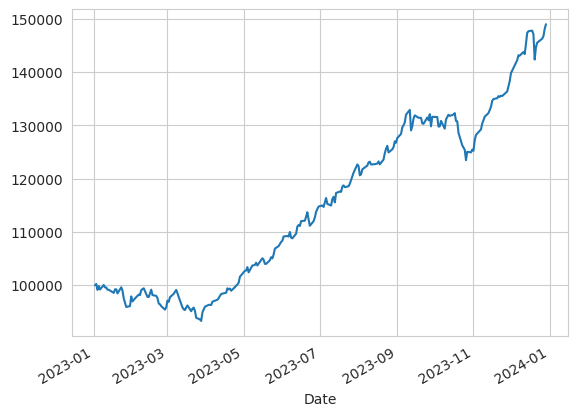

In [11]:
benchmarkdf['Portfolio Value'].plot(kind='line')

PULLING THE DATA AND FORMING A DATABASE

Best Combination: ['LUPIN.NS', 'NMDC.NS', 'ZYDUSLIFE.NS']
Best Combination Returns: 74.03 %
Best Combination Sharpe Ratio: 2.83


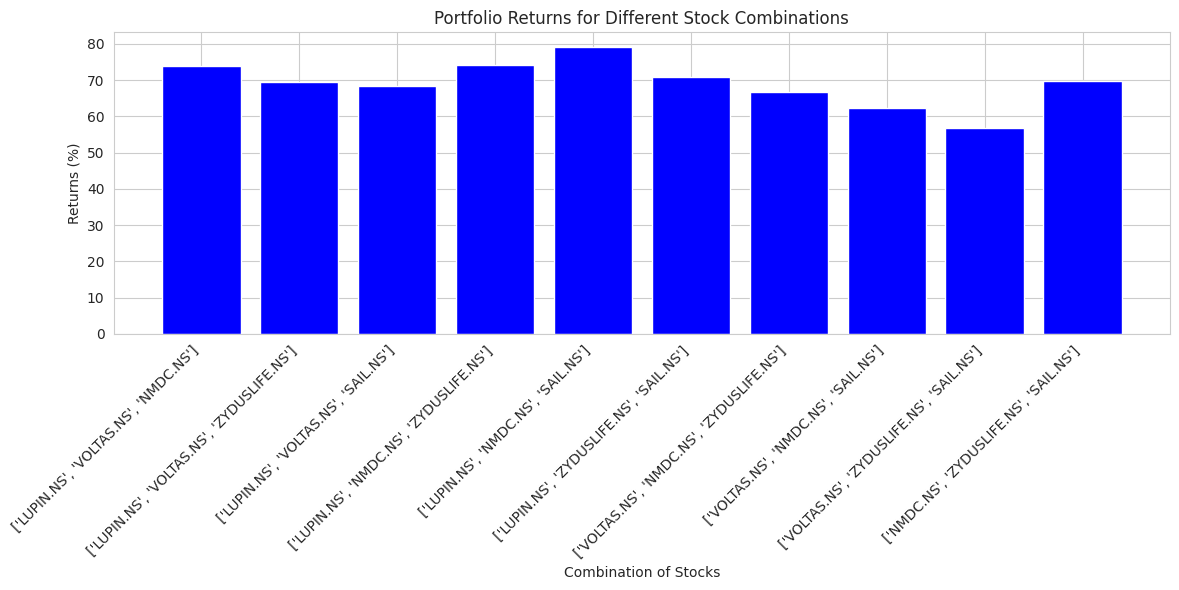

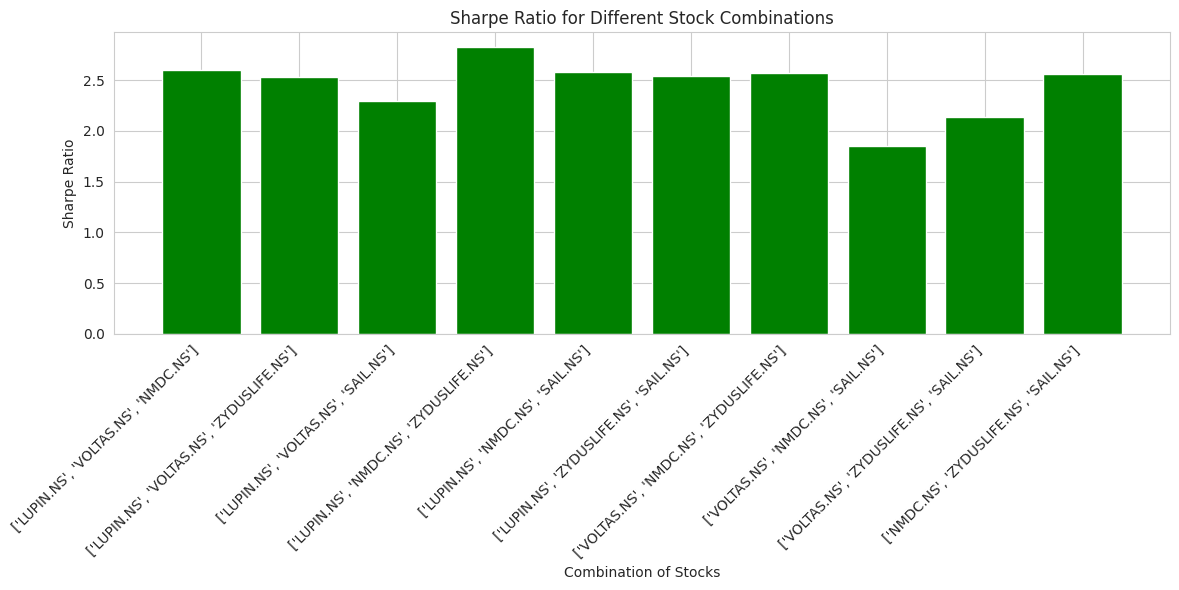

In [12]:
NUM_SIMULATIONS = 20000     # Tweak accordingly (can start with 5000-10000 for creating the code initially)
NUM_TRADING_DAYS = 252

stocks =["LUPIN.NS", "VOLTAS.NS", "NMDC.NS", "ZYDUSLIFE.NS", "SAIL.NS"]

from itertools import combinations
numbers = range(len(stocks))

# Generate all combinations of selecting 3 numbers
combs = list(combinations(numbers, 3))              # it will be something like [(0,1,2), (0,1,3)....]
combo_results = []

for comb in combs:
    stocks_new = [stocks[i] for i in comb]
    stock_data = {}
    for stock in stocks_new:
        ticker = yf.Ticker(stock)
        stock_data[stock] = ticker.history(start=st, end=ed)['Close']

    stock_prices = pd.DataFrame(stock_data)

    log_returns = np.log(stock_prices / stock_prices.shift(1))
    log_returns.dropna(inplace=True)

    portfolio_weights = []
    portfolio_returns = []
    portfolio_risks = []

    for i in range(NUM_SIMULATIONS):
        weights = np.random.random(len(stocks_new))
        weights /= np.sum(weights)
        portfolio_weights.append(weights)

        weighted_returns = np.sum(log_returns.mean() * weights) * NUM_TRADING_DAYS
        portfolio_returns.append(weighted_returns)

        portfolio_variance = np.dot(weights.T, np.dot(log_returns.cov() * NUM_TRADING_DAYS, weights))
        portfolio_std_dev = np.sqrt(portfolio_variance)
        portfolio_risks.append(portfolio_std_dev)

    risk_free_rate = 0.07
    portfolio_weights = np.array(portfolio_weights)
    portfolio_returns = np.array(portfolio_returns)
    portfolio_risks = np.array(portfolio_risks)

    sharpe_ratios = (portfolio_returns - risk_free_rate) / portfolio_risks

    ind = np.argmax(sharpe_ratios)
    weights = portfolio_weights[ind]

    df = pd.DataFrame()
    shares = [(initial_investment * weights[i]) / stock_prices.iloc[0, i] for i in range(len(weights))]
    for i, stock in enumerate(stocks_new):
        df[stock] = shares[i] * stock_prices[stock]

    df['Portfolio Value'] = df[stocks_new].sum(axis=1)
    final_portfolio_value = df['Portfolio Value'].iloc[-1]

    df_returns = (final_portfolio_value - initial_investment) * 100 / initial_investment

    combo_results.append((stocks_new, df_returns, sharpe_ratios[ind]))

# Find the best combination based on Sharpe ratio
best_combo = max(combo_results, key=lambda x: x[2])

print("Best Combination:", best_combo[0])
print("Best Combination Returns:", round(best_combo[1], 2), "%")
print("Best Combination Sharpe Ratio:", round(best_combo[2], 2))

# Visualization
combo_names = [str(comb[0]) for comb in combo_results]
returns = [comb[1] for comb in combo_results]
sharpe_ratios = [comb[2] for comb in combo_results]

plt.figure(figsize=(12, 6))
plt.bar(combo_names, returns, color='blue')
plt.xlabel('Combination of Stocks')
plt.ylabel('Returns (%)')
plt.title('Portfolio Returns for Different Stock Combinations')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.bar(combo_names, sharpe_ratios, color='green')
plt.xlabel('Combination of Stocks')
plt.ylabel('Sharpe Ratio')
plt.title('Sharpe Ratio for Different Stock Combinations')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
